Dataset shape: (569, 30)
Classes: [np.str_('malignant'), np.str_('benign')]
=== Baseline cross-validation ===
CV accuracy scores: [0.96703297 0.97802198 0.96703297 1.         0.98901099]
Mean CV accuracy: 0.9802 (+/- 0.0128)

=== Hyperparameter search (GridSearchCV) ===
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Best CV score: 0.9802

=== Test set evaluation ===
Test accuracy: 0.9825

Classification report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion matrix:
[[41  1]
 [ 1 71]]

ROC AUC: 0.9960


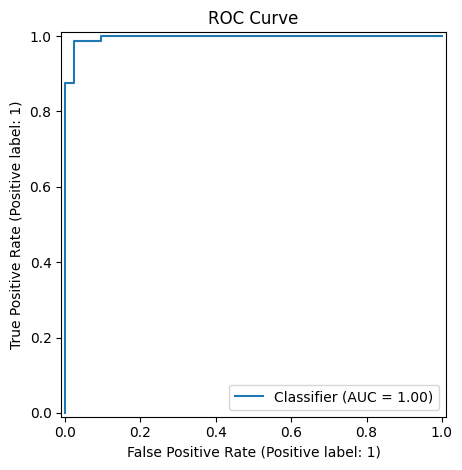


=== Top 10 most important features (by |coef|) ===
                 feature      coef
21         worst texture -0.548639
20          worst radius -0.515598
27  worst concave points -0.496777
23            worst area -0.495664
22       worst perimeter -0.472829
10          radius error -0.459034
1           mean texture -0.428021
7    mean concave points -0.413799
13            area error -0.409919
28        worst symmetry -0.405547


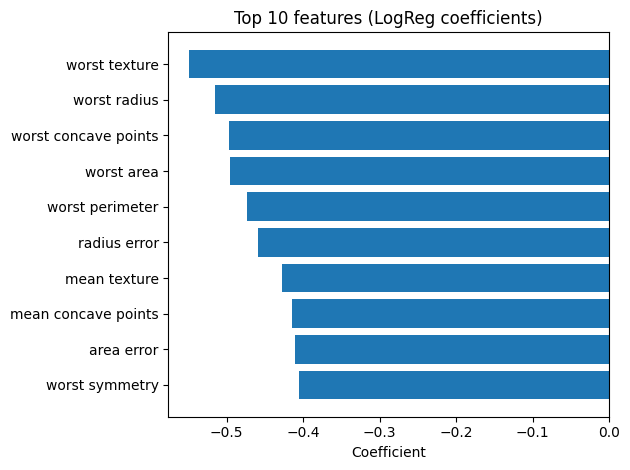

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)


def load_data():
    """
    Load a binary classification dataset.
    Here we use the built-in Breast Cancer dataset from scikit-learn.
    """
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name="target")
    return X, y, data


def split_data(X, y, test_size=0.2, random_state=42):
    """
    Split the data into train and test sets.
    """
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )


def build_pipeline():
    """
    Build a preprocessing + model pipeline.
    StandardScaler -> LogisticRegression
    """
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])
    return pipe


def baseline_training(pipe, X_train, y_train):
    """
    Train a baseline model and show cross-validation performance.
    """
    print("=== Baseline cross-validation ===")
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    print(f"CV accuracy scores: {scores}")
    print(f"Mean CV accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    pipe.fit(X_train, y_train)
    return pipe


def hyperparameter_search(pipe, X_train, y_train):
    """
    Run a grid search on the LogisticRegression hyperparameters.
    """
    print("\n=== Hyperparameter search (GridSearchCV) ===")
    param_grid = {
        "clf__C": [0.01, 0.1, 1.0, 10.0],
        "clf__penalty": ["l1", "l2"],
    }

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print(f"Best CV score: {grid.best_score_:.4f}")
    best_model = grid.best_estimator_
    return best_model


def evaluate_model(model, X_test, y_test, target_names=None):
    """
    Evaluate the model on the test set:
    - Accuracy
    - Classification report
    - Confusion matrix
    - ROC AUC
    """
    print("\n=== Test set evaluation ===")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {acc:.4f}\n")

    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\nROC AUC: {roc_auc:.4f}")

    # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve")
    plt.tight_layout()
    plt.show()


def show_feature_importance_logreg(model, feature_names):
    """
    Show feature importance for LogisticRegression (absolute coefficients).
    Only works if final estimator is LogisticRegression.
    """
    clf = model.named_steps["clf"]
    coefs = clf.coef_[0]

    importance = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
    }).sort_values("abs_coef", ascending=False)

    print("\n=== Top 10 most important features (by |coef|) ===")
    print(importance.head(10)[["feature", "coef"]])

    # Optional: bar plot
    top = importance.head(10)
    plt.figure()
    plt.barh(top["feature"], top["coef"])
    plt.gca().invert_yaxis()
    plt.title("Top 10 features (LogReg coefficients)")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()


def main():
    # 1. Load data
    X, y, data = load_data()
    print("Dataset shape:", X.shape)
    print("Classes:", list(data.target_names))

    # 2. Train / test split
    X_train, X_test, y_train, y_test = split_data(X, y)

    # 3. Build pipeline
    pipeline = build_pipeline()

    # 4. Baseline training with CV
    pipeline = baseline_training(pipeline, X_train, y_train)

    # 5. Hyperparameter search
    best_model = hyperparameter_search(pipeline, X_train, y_train)

    # 6. Final evaluation
    evaluate_model(best_model, X_test, y_test, target_names=data.target_names)

    # 7. Feature importance (LogisticRegression)
    show_feature_importance_logreg(best_model, X.columns)

main()
